<p style="font-size:32px;text-align:center"> <b>Social network Graph Link Prediction - Facebook Challenge</b> </p>

In [ ]:
#Importing Libraries
# please do go through this python notebook: 
import warnings
warnings.filterwarnings("ignore")

import csv
import pandas as pd#pandas to create small dataframes 
import datetime #Convert to unix time
import time #Convert to unix time
# if numpy is not installed already : pip3 install numpy
import numpy as np#Do aritmetic operations on arrays
# matplotlib: used to plot graphs
import matplotlib
import matplotlib.pylab as plt
import seaborn as sns#Plots
from matplotlib import rcParams#Size of plots  
from sklearn.cluster import MiniBatchKMeans, KMeans#Clustering
import math
import pickle
import os
# to install xgboost: pip3 install xgboost
import xgboost as xgb

import warnings
import networkx as nx
import pdb
import pickle
from pandas import HDFStore,DataFrame
from pandas import read_hdf
from scipy.sparse.linalg import svds, eigs
import gc
from tqdm import tqdm
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score

In [ ]:
#reading
from pandas import read_hdf
df_final_train = read_hdf('gdrive/My Drive/data/fea_sample/storage_sample_stage4.h5', 'train_df',mode='r')
df_final_test = read_hdf('gdrive/My Drive/data/fea_sample/storage_sample_stage4.h5', 'test_df',mode='r')

In [ ]:
df_final_train.columns

Index(['source_node', 'destination_node', 'indicator_link',
       'jaccard_followers', 'jaccard_followees', 'cosine_followers',
       'cosine_followees', 'num_followers_s', 'num_followees_s',
       'num_followees_d', 'inter_followers', 'inter_followees', 'adar_index',
       'follows_back', 'same_comp', 'shortest_path', 'weight_in', 'weight_out',
       'weight_f1', 'weight_f2', 'weight_f3', 'weight_f4', 'page_rank_s',
       'page_rank_d', 'katz_s', 'katz_d', 'hubs_s', 'hubs_d', 'authorities_s',
       'authorities_d', 'svd_u_s_1', 'svd_u_s_2', 'svd_u_s_3', 'svd_u_s_4',
       'svd_u_s_5', 'svd_u_s_6', 'svd_u_d_1', 'svd_u_d_2', 'svd_u_d_3',
       'svd_u_d_4', 'svd_u_d_5', 'svd_u_d_6', 'svd_v_s_1', 'svd_v_s_2',
       'svd_v_s_3', 'svd_v_s_4', 'svd_v_s_5', 'svd_v_s_6', 'svd_v_d_1',
       'svd_v_d_2', 'svd_v_d_3', 'svd_v_d_4', 'svd_v_d_5', 'svd_v_d_6'],
      dtype='object')

In [ ]:
#add new features

if os.path.isfile('gdrive/My Drive/data/after_eda/train_pos_after_eda.csv'):
    train_graph=nx.read_edgelist('gdrive/My Drive/data/after_eda/train_pos_after_eda.csv',delimiter=',',create_using=nx.DiGraph(),nodetype=int)
    print(nx.info(train_graph))
else:
    print("please run the FB_EDA.ipynb or download the files from drive")

Name: 
Type: DiGraph
Number of nodes: 1780722
Number of edges: 7550015
Average in degree:   4.2399
Average out degree:   4.2399


# Assignments:

1. Add another feature called  Preferential Attachment  with followers and followees data of vertex. you can check about Preferential Attachment in below link
http://be.amazd.com/link-prediction/ <br>
2. Add  feature called svd_dot. you can calculate svd_dot as Dot product between sourse node svd and destination node svd features.  you can read about this in below pdf 
https://storage.googleapis.com/kaggle-forum-message-attachments/2594/supervised_link_prediction.pdf<br>
3. Tune hyperparameters for XG boost with all these features and check the error metric.

In [ ]:

# preferential attachment 

def p_attachment(a,b):

   try:
        if (len(set(train_graph.predecessors(a))) == 0)  | (len(set(train_graph.predecessors(b))) == 0):
            return 0
          
        score = (len(set(train_graph.predecessors(a))))*(len(set(train_graph.predecessors(b))))       
        return score 
   except:
        return 0
   


In [ ]:
#one test case
print(p_attachment(2,470294))

60


In [ ]:
df_final_train['pref_attachment'] = df_final_train.apply(lambda row:
                                            p_attachment(row['source_node'],row['destination_node']),axis=1)
df_final_test['pref_attachment'] = df_final_test.apply(lambda row:
                                            p_attachment(row['source_node'],row['destination_node']),axis=1)

In [ ]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attachment
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598


In [ ]:
# svd_dot

df_final_train["svd_dot_u"] = df_final_train['svd_u_s_1']*df_final_train['svd_u_d_1'] + df_final_train['svd_u_s_2']*df_final_train['svd_u_d_2'] + df_final_train['svd_u_s_3']*df_final_train['svd_u_d_3'] + df_final_train['svd_u_s_4']*df_final_train['svd_u_d_4'] + df_final_train['svd_u_s_5']*df_final_train['svd_u_d_5'] + df_final_train['svd_u_s_6']*df_final_train['svd_u_d_6']
df_final_train["svd_dot_v"] = df_final_train['svd_v_s_1']*df_final_train['svd_v_d_1'] + df_final_train['svd_v_s_2']*df_final_train['svd_v_d_2'] + df_final_train['svd_v_s_3']*df_final_train['svd_v_d_3'] + df_final_train['svd_v_s_4']*df_final_train['svd_v_d_4'] + df_final_train['svd_v_s_5']*df_final_train['svd_v_d_5'] + df_final_train['svd_v_s_6']*df_final_train['svd_v_d_6']


df_final_test["svd_dot_u"] = df_final_test['svd_u_s_1']*df_final_test['svd_u_d_1'] + df_final_test['svd_u_s_2']*df_final_test['svd_u_d_2'] + df_final_test['svd_u_s_3']*df_final_test['svd_u_d_3'] + df_final_test['svd_u_s_4']*df_final_test['svd_u_d_4'] + df_final_test['svd_u_s_5']*df_final_test['svd_u_d_5'] + df_final_test['svd_u_s_6']*df_final_test['svd_u_d_6']
df_final_test["svd_dot_v"] = df_final_test['svd_v_s_1']*df_final_test['svd_v_d_1'] + df_final_test['svd_v_s_2']*df_final_test['svd_v_d_2'] + df_final_test['svd_v_s_3']*df_final_test['svd_v_d_3'] + df_final_test['svd_v_s_4']*df_final_test['svd_v_d_4'] + df_final_test['svd_v_s_5']*df_final_test['svd_v_d_5'] + df_final_test['svd_v_s_6']*df_final_test['svd_v_d_6']

In [ ]:
df_final_train.head(2)

,source_node,destination_node,indicator_link,jaccard_followers,jaccard_followees,cosine_followers,cosine_followees,num_followers_s,num_followees_s,num_followees_d,inter_followers,inter_followees,adar_index,follows_back,same_comp,shortest_path,weight_in,weight_out,weight_f1,weight_f2,weight_f3,weight_f4,page_rank_s,page_rank_d,katz_s,katz_d,hubs_s,hubs_d,authorities_s,authorities_d,svd_u_s_1,svd_u_s_2,svd_u_s_3,svd_u_s_4,svd_u_s_5,svd_u_s_6,svd_u_d_1,svd_u_d_2,svd_u_d_3,svd_u_d_4,svd_u_d_5,svd_u_d_6,svd_v_s_1,svd_v_s_2,svd_v_s_3,svd_v_s_4,svd_v_s_5,svd_v_s_6,svd_v_d_1,svd_v_d_2,svd_v_d_3,svd_v_d_4,svd_v_d_5,svd_v_d_6,pref_attachment,svd_dot_u,svd_dot_v
0,273084,1505602,1,0,0.000000,0.000000,0.000000,6,15,8,0,0,0.000000,0,1,4,0.377964,0.250,0.627964,0.094491,1.005929,0.877964,2.045290e-06,3.459963e-07,0.000773,0.000756,1.943132e-13,1.941103e-13,9.226339e-16,2.231877e-15,-1.666226e-13,4.613397e-13,1.043044e-05,6.676960e-13,2.451081e-13,3.584580e-12,-2.038017e-11,5.397495e-13,1.068946e-06,1.192357e-12,2.279485e-12,3.580837e-12,-7.216133e-13,3.925975e-13,1.983691e-06,1.545075e-13,8.108434e-13,1.719702e-14,-1.355368e-12,4.675307e-13,1.128591e-06,6.616550e-14,9.771077e-13,4.159752e-14,66,1.114958e-11,2.238775e-12
1,832016,1543415,1,0,0.187135,0.028382,0.343828,94,61,142,11,32,16.362912,0,1,2,0.102598,0.127,0.229598,0.013030,0.332196,0.356598,2.353458e-07,6.427660e-07,0.000845,0.001317,3.906648e-11,9.424102e-11,1.208074e-11,1.273080e-10,7.051088e-13,-8.250564e-11,-1.717702e-10,3.705016e-02,1.032392e-11,7.207497e-10,1.644399e-12,-2.047752e-10,-3.943936e-10,8.617541e-02,2.399540e-11,1.738682e-09,2.685878e-13,-3.316849e-11,-6.236048e-11,1.345726e-02,3.703479e-12,2.251737e-10,1.245101e-12,-1.636948e-10,-3.112650e-10,6.738902e-02,2.607801e-11,2.372904e-09,1598,3.192812e-03,9.068719e-04


In [ ]:
y_train = df_final_train.indicator_link
y_test = df_final_test.indicator_link

In [ ]:
df_final_train.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)
df_final_test.drop(['source_node', 'destination_node','indicator_link'],axis=1,inplace=True)

Estimators =  10 Train Score 0.9302179379715004 test Score 0.9264801835364441
Estimators =  50 Train Score 0.9725705568268497 test Score 0.9324773829954024
Estimators =  100 Train Score 0.9764297497242209 test Score 0.9296007459523606
Estimators =  250 Train Score 0.9855419504784134 test Score 0.9272449109685097
Estimators =  450 Train Score 0.9940705128205127 test Score 0.9216402760860739


Text(0.5, 1.0, 'Estimators vs score at depth of 5')

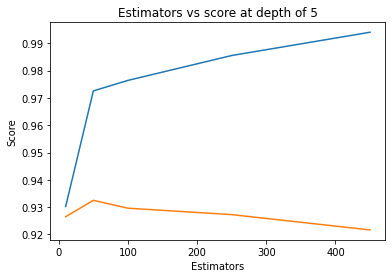

In [ ]:
# from numpy import loadtxt
from xgboost import XGBClassifier
import xgboost as xgb

estimators = [10,50,100,250,450]
train_scores = []
test_scores = []
for i in estimators:
    clf = XGBClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=i, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('Estimators = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(estimators,train_scores,label='Train Score')
plt.plot(estimators,test_scores,label='Test Score')
plt.xlabel('Estimators')
plt.ylabel('Score')
plt.title('Estimators vs score at depth of 5')

depth =  3 Train Score 0.9742509695122569 test Score 0.926185619581846
depth =  9 Train Score 0.9901541181907689 test Score 0.9282321004411267
depth =  11 Train Score 0.995609990778976 test Score 0.9272186836518046
depth =  15 Train Score 0.9999900098902087 test Score 0.9277182560729819
depth =  20 Train Score 1.0 test Score 0.9291251853420884
depth =  35 Train Score 1.0 test Score 0.9305473310210644
depth =  50 Train Score 1.0 test Score 0.9305020938200583
depth =  70 Train Score 1.0 test Score 0.9305020938200583
depth =  130 Train Score 1.0 test Score 0.9305020938200583


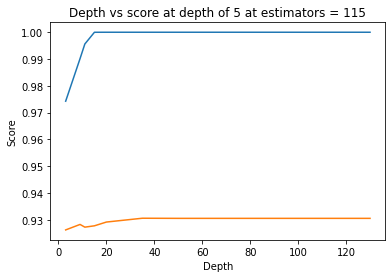

In [ ]:
depths = [3,9,11,15,20,35,50,70,130]
train_scores = []
test_scores = []
for i in depths:
    clf = XGBClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=i, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,
            min_weight_fraction_leaf=0.0, n_estimators=115, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('depth = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(depths,train_scores,label='Train Score')
plt.plot(depths,test_scores,label='Test Score')
plt.xlabel('Depth')
plt.ylabel('Score')
plt.title('Depth vs score at depth of 5 at estimators = 115')
plt.show()

learning_rate =  0.0001 Train Score 0.9262623677925622 test Score 0.9250861755197294
learning_rate =  0.001 Train Score 0.9262623677925622 test Score 0.9250861755197294
learning_rate =  0.01 Train Score 0.9288014539425438 test Score 0.9282317060165931
learning_rate =  0.1 Train Score 0.9725705568268497 test Score 0.9324773829954024
learning_rate =  0.2 Train Score 0.976986029761363 test Score 0.9289608213308443
learning_rate =  0.3 Train Score 0.9809717906291618 test Score 0.9280332774464654


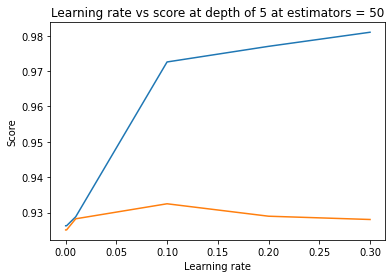

In [ ]:
learning_rates = [0.0001, 0.001, 0.01, 0.1, 0.2, 0.3] 
train_scores = []
test_scores = []
for i in learning_rates:
    clf = XGBClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=5, max_features='auto', max_leaf_nodes=None,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=52, min_samples_split=120,learning_rate = i,
            min_weight_fraction_leaf=0.0, n_estimators=50, n_jobs=-1,random_state=25,verbose=0,warm_start=False)
    clf.fit(df_final_train,y_train)
    train_sc = f1_score(y_train,clf.predict(df_final_train))
    test_sc = f1_score(y_test,clf.predict(df_final_test))
    test_scores.append(test_sc)
    train_scores.append(train_sc)
    print('learning_rate = ',i,'Train Score',train_sc,'test Score',test_sc)
plt.plot(learning_rates,train_scores,label='Train Score')
plt.plot(learning_rates,test_scores,label='Test Score')
plt.xlabel('Learning rate')
plt.ylabel('Score')
plt.title('Learning rate vs score at depth of 5 at estimators = 50')
plt.show()

In [ ]:
from sklearn.metrics import f1_score
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import f1_score
from sklearn.model_selection import RandomizedSearchCV
from scipy.stats import randint as sp_randint
from scipy.stats import uniform

param_dist = {"n_estimators":sp_randint(105,125),
              "max_depth": sp_randint(10,15),
              "learning_rate" :  uniform(0, 0.5),
              "min_samples_split": sp_randint(110,190),
              "min_samples_leaf": sp_randint(25,65)}

clf = XGBClassifier(random_state=25,n_jobs=-1)

rf_random = RandomizedSearchCV(clf, param_distributions=param_dist,
                                   n_iter=5,cv=10,scoring='f1',random_state=25,return_train_score=True )

rf_random.fit(df_final_train,y_train)
print('mean test scores',rf_random.cv_results_['mean_test_score'])
print('mean train scores',rf_random.cv_results_['mean_train_score'])

mean test scores [0.98213385 0.97839996 0.98156632 0.98164238 0.98172098]
mean train scores [1.         0.98694126 1.         1.         0.99957247]


In [ ]:
print(rf_random.best_estimator_)

XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.43506206831360594, max_delta_step=0, max_depth=12,
              min_child_weight=1, min_samples_leaf=40, min_samples_split=171,
              missing=None, n_estimators=117, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=25, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)


In [ ]:
clf = XGBClassifier(base_score=0.5, booster='gbtree', colsample_bylevel=1,
              colsample_bynode=1, colsample_bytree=1, gamma=0,
              learning_rate=0.43506206831360594, max_delta_step=0, max_depth=12,
              min_child_weight=1, min_samples_leaf=40, min_samples_split=171,
              missing=None, n_estimators=117, n_jobs=-1, nthread=None,
              objective='binary:logistic', random_state=25, reg_alpha=0,
              reg_lambda=1, scale_pos_weight=1, seed=None, silent=None,
              subsample=1, verbosity=1)

In [ ]:
clf.fit(df_final_train,y_train)
y_train_pred = clf.predict(df_final_train)
y_test_pred = clf.predict(df_final_test)

In [ ]:
from sklearn.metrics import f1_score
print('Train f1 score',f1_score(y_train,y_train_pred))
print('Test f1 score',f1_score(y_test,y_test_pred))

# Test scores are quite good but with a bit of overfitting

Train f1 score 1.0
Test f1 score 0.9257434154630417


In [ ]:
from sklearn.metrics import confusion_matrix
def plot_confusion_matrix(test_y, predict_y):
    C = confusion_matrix(test_y, predict_y)
    
    A =(((C.T)/(C.sum(axis=1))).T)
    
    B =(C/C.sum(axis=0))
    plt.figure(figsize=(20,4))
    
    labels = [0,1]
    # representing A in heatmap format
    cmap=sns.light_palette("blue")
    plt.subplot(1, 3, 1)
    sns.heatmap(C, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Confusion matrix")
    
    plt.subplot(1, 3, 2)
    sns.heatmap(B, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Precision matrix")
    
    plt.subplot(1, 3, 3)
    # representing B in heatmap format
    sns.heatmap(A, annot=True, cmap=cmap, fmt=".3f", xticklabels=labels, yticklabels=labels)
    plt.xlabel('Predicted Class')
    plt.ylabel('Original Class')
    plt.title("Recall matrix")
    
    plt.show()

Train confusion_matrix


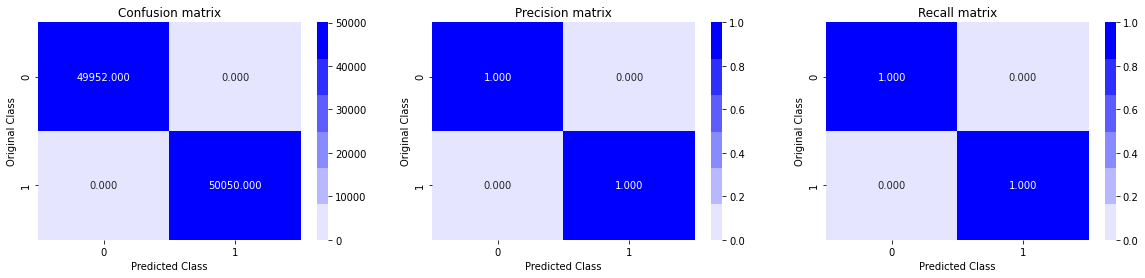

Test confusion_matrix


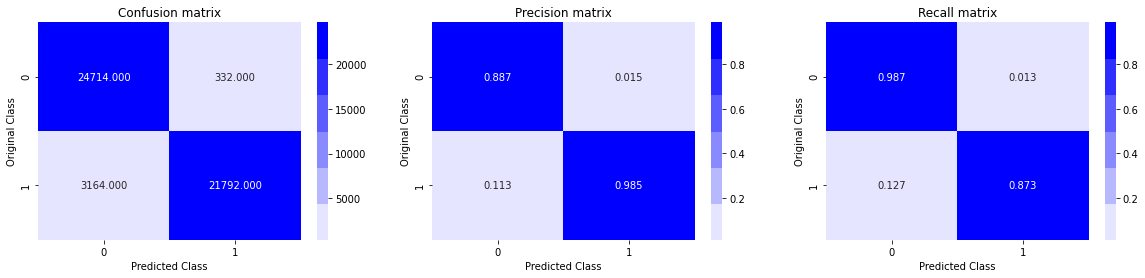

In [ ]:
print('Train confusion_matrix')
plot_confusion_matrix(y_train,y_train_pred)
print('Test confusion_matrix')
plot_confusion_matrix(y_test,y_test_pred)

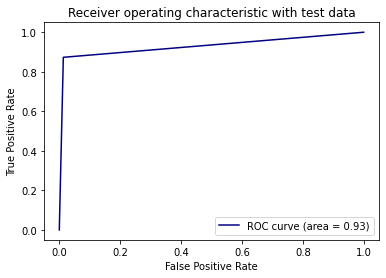

In [ ]:
from sklearn.metrics import roc_curve, auc
fpr,tpr,ths = roc_curve(y_test,y_test_pred)
auc_sc = auc(fpr, tpr)
plt.plot(fpr, tpr, color='navy',label='ROC curve (area = %0.2f)' % auc_sc)
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('Receiver operating characteristic with test data')
plt.legend()
plt.show()

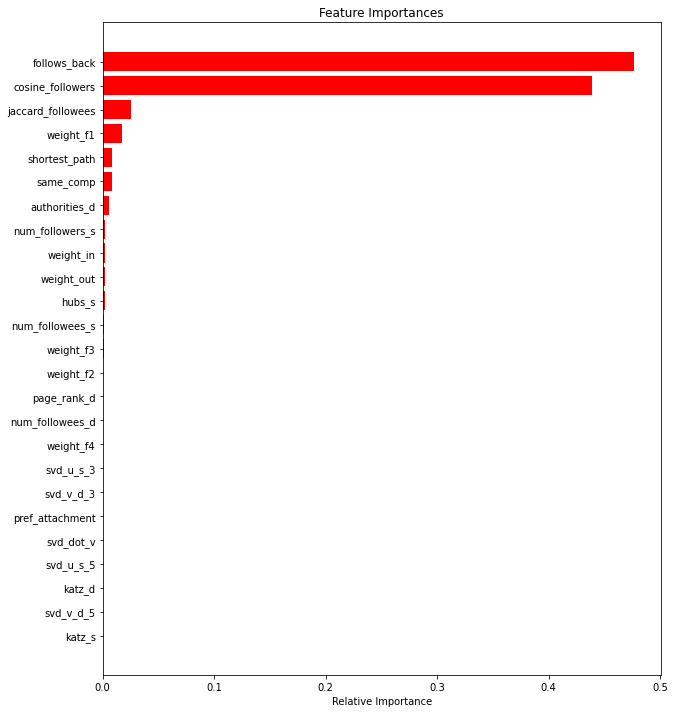

In [ ]:
features = df_final_train.columns
importances = clf.feature_importances_
indices = (np.argsort(importances))[-25:]
plt.figure(figsize=(10,12))
plt.title('Feature Importances')
plt.barh(range(len(indices)), importances[indices], color='r', align='center')
plt.yticks(range(len(indices)), [features[i] for i in indices])
plt.xlabel('Relative Importance')
plt.show()

In [ ]:
# Features importance of follows_back and cosine_followers are much higher than the rest of the features